In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt # we only need pyplot
sns.set() # set the default Seaborn style for graphics

In [2]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

# authenticate
credential = DefaultAzureCredential()

SUBSCRIPTION = "ff4267dd-bc39-4e59-ad85-27f549d74fbb"
RESOURCE_GROUP = "Machine_Learning"
WS_NAME = "KMC_Solutions_ML"
# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id=SUBSCRIPTION,
    resource_group_name=RESOURCE_GROUP,
    workspace_name=WS_NAME,
)


ModuleNotFoundError: No module named 'azure'

In [5]:
file = 'data/01_raw/ref.csv'
df = pd.read_csv(file, encoding='ISO-8859-1', skipinitialspace = True)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/01_raw/ref.csv'

In [3]:
# Extract Description and Department column
df = df[['Description', 'Department']]
# Get unique Department
departments = df['Department'].unique()
descriptions = df['Description']

In [4]:
df['Description'][600]

'Tickets related to inquiries or requests concerning mental health support, benefits, resources and policies.'

In [5]:
rows = []
for description in descriptions:
    row = {'Description': description}
    for department in departments:
        row[department] = 1 if department in df[df['Description'] == description]['Department'].values else 0
    rows.append(row)

In [6]:
new_df = pd.DataFrame(rows, columns=['Description'] + list(departments))

In [7]:
new_df.head()

,Description,Technology Services,Finance,Projects & Design,Engineering,HR,Customer Success,Document Controller,Legal & Compliance,Marketing,Service Delivery External,Operations Team
0,Request to reactivate a users biometric access.,1,0,0,0,0,0,0,0,0,0,0
1,Request to upload an access to another biometr...,1,0,0,0,0,0,0,0,0,0,0
2,Request to re-assign a badge card to a differe...,1,0,0,0,0,0,0,0,0,0,0
3,Request for badge card (ITS is already present...,1,0,0,0,0,0,0,0,0,0,0
4,Request to disable a biometric access.,1,0,0,0,0,0,0,0,0,0,0


In [8]:
# Calculate the sum of each department's column
x = new_df.iloc[:, 1:].sum()

# Calculate the sum of each row to determine the number of labels per description
rowsums = new_df.iloc[:, 1:].sum(axis=1)

# Count the number of descriptions without any label
no_label_count = (rowsums == 0).sum()

print("Total number of descriptions =", len(new_df))
print("Total number of descriptions without label =", no_label_count)
print("Total labels =", x.sum())

Total number of descriptions = 931
Total number of descriptions without label = 0
Total labels = 931


<ipython-input-9-4d2e1aacd114>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x.values, y=x.index, palette="viridis", alpha=0.8)


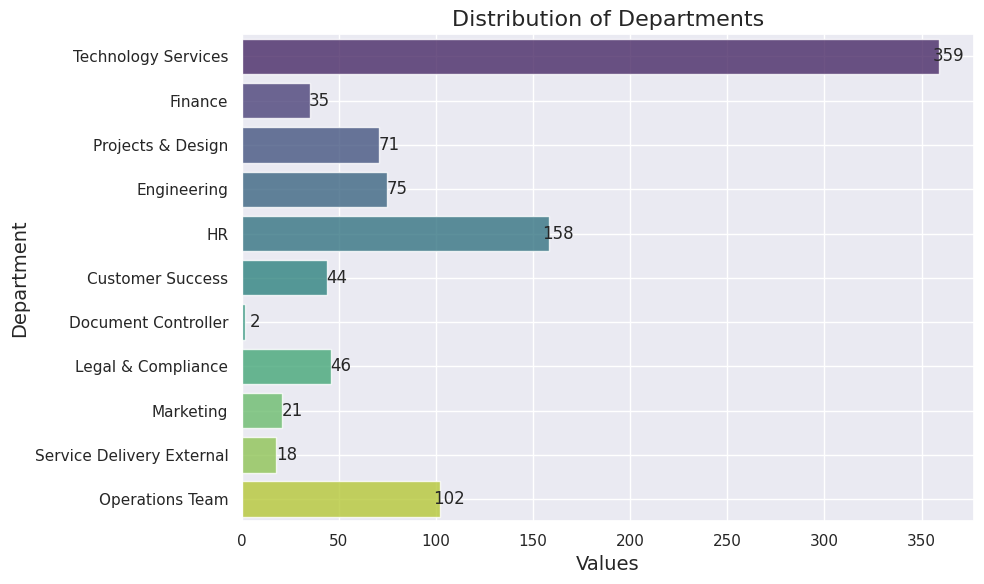

In [9]:
plt.figure(figsize=(10, 6))  # Adjust the figure size
ax = sns.barplot(x=x.values, y=x.index, palette="viridis", alpha=0.8)

# Add labels to the bars
for rect, label in zip(ax.patches, x.values):
    width = rect.get_width()
    ax.text(width + 5, rect.get_y() + rect.get_height() / 2, label, ha='center', va='center')

# Add labels and title
plt.xlabel('Values', fontsize=14)  # Add x-axis label
plt.ylabel('Department', fontsize=14)  # Add y-axis label
plt.title('Distribution of Departments', fontsize=16)  # Increase title font size

plt.grid(True)  # Add a grid
plt.tight_layout()  # Ensure the entire plot fits into the figure area
plt.show()

## Text Pre-Processing

In [10]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [11]:
train_data = new_df

In [12]:
#Remove Stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

#Clean Text
def clean_text(text):
    text = text.lower()
    text = re.sub("[^a-zA-Z]"," ",text)
    text = ' '.join(text.split())
    return text

#stemming
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

train_data['Text'] = train_data['Description'].apply(lambda x: remove_stopwords(x))
train_data['Text'] = train_data['Description'].apply(lambda x:clean_text(x))
train_data['Text'] = train_data['Description'].apply(stemming)

In [13]:
train_data['Description'] = train_data['Text']
train_data.drop('Text', inplace=True, axis=1)

### Transformed into a simpler binary classification problem

In [14]:
train_data

,Description,Technology Services,Finance,Projects & Design,Engineering,HR,Customer Success,Document Controller,Legal & Compliance,Marketing,Service Delivery External,Operations Team
0,request to reactiv a user biometr access.,1,0,0,0,0,0,0,0,0,0,0
1,request to upload an access to anoth biometr d...,1,0,0,0,0,0,0,0,0,0,0
2,request to re-assign a badg card to a differ u...,1,0,0,0,0,0,0,0,0,0,0
3,request for badg card (it is alreadi present o...,1,0,0,0,0,0,0,0,0,0,0
4,request to disabl a biometr access.,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
926,ani ticket relat to variat order quotat request.,0,0,0,0,0,0,0,0,0,0,1
927,ani ticket relat to variat order quotat review.,0,0,0,0,0,0,0,0,0,0,1
928,ani ticket relat to review of additive-deduct ...,0,0,0,0,0,0,0,0,0,0,1
929,ani ticket relat to inpuut analysi for post pr...,0,0,0,0,0,0,0,0,0,0,1


In [15]:
!pip3 install datasets transformers evaluate sentencepiece accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (4

## DeBERT Model

In [16]:
!pip install datasets

In [17]:
from sklearn.model_selection import train_test_split
train_dataset, test_dataset = train_test_split(train_data, test_size=0.2, random_state=42)

In [18]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_dataset)
test_dataset = Dataset.from_pandas(test_dataset)

In [19]:
train_dataset

Dataset({
    features: ['Description', 'Technology Services', 'Finance', 'Projects & Design', 'Engineering', 'HR', 'Customer Success', 'Document Controller', 'Legal & Compliance', 'Marketing', 'Service Delivery External', 'Operations Team', '__index_level_0__'],
    num_rows: 744
})

In [21]:
departments = [col for col in train_dataset.column_names if col != 'Description']

In [22]:
departments = departments[:-1]
print(departments)

['Technology Services', 'Finance', 'Projects & Design', 'Engineering', 'HR', 'Customer Success', 'Document Controller', 'Legal & Compliance', 'Marketing', 'Service Delivery External', 'Operations Team']


In [23]:
department2id = {department: id for id, department in enumerate(departments)}
id2department = {id:department for department, id in department2id.items()}

In [24]:
department2id, id2department

({'Technology Services': 0,
  'Finance': 1,
  'Projects & Design': 2,
  'Engineering': 3,
  'HR': 4,
  'Customer Success': 5,
  'Document Controller': 6,
  'Legal & Compliance': 7,
  'Marketing': 8,
  'Service Delivery External': 9,
  'Operations Team': 10},
 {0: 'Technology Services',
  1: 'Finance',
  2: 'Projects & Design',
  3: 'Engineering',
  4: 'HR',
  5: 'Customer Success',
  6: 'Document Controller',
  7: 'Legal & Compliance',
  8: 'Marketing',
  9: 'Service Delivery External',
  10: 'Operations Team'})

### Tokenize and Process Department Label

In [25]:
from transformers import AutoTokenizer
model_path = 'microsoft/deberta-v3-small'
tokenizer = AutoTokenizer.from_pretrained(model_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [26]:
def preprocess_function(example):
  text = example["Description"]
  labels = [0. for _ in range(len(departments))]
  for department in departments:
      if example[department] == 1:
          label_id = department2id[department]
          labels[label_id] = 1.

  example = tokenizer(text, truncation=True, padding='max_length', max_length=512)
  example['labels'] = labels
  return example

In [27]:
tokenized_train_dataset = train_dataset.map(preprocess_function)

Map:   0%|          | 0/744 [00:00<?, ? examples/s]

In [28]:
tokenized_test_dataset = test_dataset.map(preprocess_function)

Map:   0%|          | 0/187 [00:00<?, ? examples/s]

In [29]:
tokenized_test_dataset

Dataset({
    features: ['Description', 'Technology Services', 'Finance', 'Projects & Design', 'Engineering', 'HR', 'Customer Success', 'Document Controller', 'Legal & Compliance', 'Marketing', 'Service Delivery External', 'Operations Team', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 187
})

In [30]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### Evaluation Metrics

In [31]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = sigmoid(predictions)
    predictions = (predictions > 0.5).astype(int)

    # Compute metrics
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='micro')
    precision = precision_score(labels, predictions, average='micro')
    recall = recall_score(labels, predictions, average='micro')

    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}

### Model

In [33]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
   model_path, num_labels=len(departments),
           id2label=id2department, label2id=department2id,
                       problem_type = "multi_label_classification")

pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
training_args = TrainingArguments(

   output_dir="my_awesome_model",
   learning_rate=2e-5,
   per_device_train_batch_size=8,
   per_device_eval_batch_size=8,
   num_train_epochs=5,
   weight_decay=0.01,
   evaluation_strategy="epoch",
   save_strategy="epoch",
   load_best_model_at_end=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [35]:
# Initialize the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.262384,0.000000,0.000000,0.000000,0.000000
2,No log,0.219600,0.294118,0.448980,0.948276,0.294118
3,No log,0.188118,0.363636,0.521073,0.918919,0.363636
4,No log,0.170187,0.411765,0.551971,0.836957,0.411765


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Testing Text

In [ ]:
trainer.evaluate()